### **Multi Armed Bandits for Music Recommendation System**


**Spotify DJ Feature:** the goal of the feature is to have a reinforcment learning "DJ" play one song after another until some defined termination condition is met. The functionality of the proposed feature is as follows:
1. User selects a starting song
2. Using that starting song, we use the association algorithm to select the next candidates of length n using a track feature analyzer
3. The candidate songs will be structured as a 2-D array of shape (4,n)
3. This set of candidates act as the "environment" for Spotify DJ to interact with where n1...nt are the sets of candidates for each time step
4. The candidates will all be populated with the same formula to maintain consistency and more importantly, represent a true multi armed bandit problem
5. This project will simulate user feedback which will be used to adjust user preferences for each session activated

Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import json
import random
from statistics import mean
import time
import sys
import csv

%matplotlib inline

Spotify API

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

# client_id = REDACTED
# client_secret = REDACTED
client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Import Spotify Million Playlist Dataset:
- Using only 2% of total to reduce memory consumption

In [3]:
def slices(path, num_slices=20):
    count = 0
    playlists = []
    filenames = os.listdir(path)

    for fname in sorted(filenames):

        if fname.startswith("mpd.slice.") and fname.endswith(".json"):
            count += 1
            fullpath = os.sep.join((path, fname))
            f = open(fullpath)
            js = f.read()
            f.close()
            current_slice = json.loads(js)

        # Create a list of all playlists
        for playlist in current_slice['playlists']:
            playlists.append(playlist)

        if count == num_slices:
            break

    return playlists


# Path where the json files are extracted
path = 'spotify_million_playlist_dataset/data/'
playlists = slices(path, num_slices=20)

Example playlist

In [4]:
playlists[1234]

{'name': 'Dance Dance',
 'collaborative': 'false',
 'pid': 1234,
 'modified_at': 1385510400,
 'num_tracks': 46,
 'num_albums': 40,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'David Guetta',
   'track_uri': 'spotify:track:2dOTkLZFbpNXrhc24CnTFd',
   'artist_uri': 'spotify:artist:1Cs0zKBU1kc0i8ypK3B9ai',
   'track_name': 'Titanium (feat. Sia) - feat. Sia',
   'album_uri': 'spotify:album:1fAn5gw4Q5HN8Wpx2neYd2',
   'duration_ms': 245053,
   'album_name': 'Nothing But the Beat Ultimate'},
  {'pos': 1,
   'artist_name': 'David Guetta',
   'track_uri': 'spotify:track:0ywi1OJ1YNVkZ9FBW5h3RP',
   'artist_uri': 'spotify:artist:1Cs0zKBU1kc0i8ypK3B9ai',
   'track_name': 'Paris',
   'album_uri': 'spotify:album:3evsUmSaqqRzNeOTzuhpBP',
   'duration_ms': 280608,
   'album_name': 'Nothing But The Beat - The Electronic Album'},
  {'pos': 2,
   'artist_name': 'Madonna',
   'track_uri': 'spotify:track:0QXtw4rDLQtpzqPS4uJbZJ',
   'artist_uri': 'spotify:artist:6tbjWDEIzxoDsBA1FuhfPW',
 

In [5]:
sp.audio_features(tracks = ['spotify:track:3cHyrEgdyYRjgJKSOiOtcS'])

[{'danceability': 0.581,
  'energy': 0.963,
  'key': 11,
  'loudness': -4.087,
  'mode': 1,
  'speechiness': 0.0981,
  'acousticness': 0.0295,
  'instrumentalness': 0,
  'liveness': 0.139,
  'valence': 0.788,
  'tempo': 129.992,
  'type': 'audio_features',
  'id': '3cHyrEgdyYRjgJKSOiOtcS',
  'uri': 'spotify:track:3cHyrEgdyYRjgJKSOiOtcS',
  'track_href': 'https://api.spotify.com/v1/tracks/3cHyrEgdyYRjgJKSOiOtcS',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/3cHyrEgdyYRjgJKSOiOtcS',
  'duration_ms': 204160,
  'time_signature': 4}]

**Explore Spotify Million Playlist Sample Dataset**

In [6]:
# observing the range of playlist lengths

playlist_lengths = [playlist['num_tracks'] for playlist in playlists]

smallest_playlist = min(playlist_lengths)
largest_playlist = max(playlist_lengths)
    
print(f"The smallest playlist from sample is {smallest_playlist} songs and the largest is {largest_playlist} songs.")  

The smallest playlist from sample is 5 songs and the largest is 250 songs.


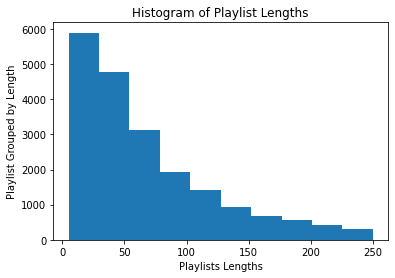

In [7]:
# Plot playlist lengths

plt.hist(playlist_lengths, 10)
plt.xlabel('Playlists Lengths')
plt.ylabel('Playlist Grouped by Length')
plt.title('Histogram of Playlist Lengths')
plt.show()

In [8]:
import statistics

mean_length = statistics.mean(playlist_lengths)
median_length = statistics.median(playlist_lengths)

print(f"The average playlist length is {mean_length} and the median length is {median_length}.")

The average playlist length is 66.9981 and the median length is 49.0.


In [9]:
count = 0
for playlist in playlists:
    count += playlist['num_tracks']
print(f"Total songs in playlist sample: {count}")

Total songs in playlist sample: 1339962


##### Create Track Analyzer Class

In [10]:
# Analyzer class to find song and song features to create candidates

class Analyzer: 
    
    @classmethod
    def Find(cls): #searches for a song within 20,000 playlists imported
        while True:
            temp_ = {} # store temporary results
            search = str(input('Please enter a song to search: '))
            count = 0
            for playlist in playlists:
                for tracks in playlist['tracks']:
                    if tracks['track_name'].lower() == search.lower():                                                
                        count += 1
                        temp_[count] = tracks['artist_name'], tracks['track_name'], tracks['track_uri']
            
            # remove potential duplicates in results
            temp = []
            final = dict()
            for key, val in temp_.items():
                if val not in temp:
                    temp.append(val)
                    final[key] = val

            # loop back to query if search does not return any results
            if len(final) == 0:
                print('No matches found.')
                continue
            # this imitates a UI where a user would select/tap the song they desire
            else:
                print('Here are your results:')
                print(final)
                selection = int(input('Please select the key of song dictionary you would like to select, or press 0 to exit. '))
                if selection == 0:
                    break
                else:
                    return final[selection][-1]              

    
    @classmethod
    def Features(cls, song): # extract raw track features using spotipy
        
        features = sp.audio_features(tracks = [song])
        removable_features = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms']
        features_final = {}
        
        for feat in features:
            for i in removable_features:
                del feat[i]
            
        # keep only qualitative features for measurement
        features_final = [value for item in features for value in item.values()]
        
        # normalize features using MinMaxScaler
        min_ = min(features_final)
        max_ = max(features_final)
        for i, x in enumerate(features_final):
            features_final[i] = (x - min_) / (max_ - min_)
        return features_final
    
    
    # candidate generator function
    @classmethod
    def Collaborative(cls, uri): # returns candidates using a collaborative method using the imported playlists as a based policy
        starting_song = uri
        candidates = []
        artists = []
        
        # iterate through all 20,000 playlists
        for playlist in playlists:
            for index, item in enumerate(playlist['tracks']):
                if item['track_uri'] == starting_song: 
                    candidates.append([item['track_uri'] for item in playlist['tracks']])
                
        candidates_flat = [element for innerlist in candidates for element in innerlist]
        
        # choose random 40 from pool of candidates
        random_40 = []
        while len(random_40) < 40:
            x = np.random.choice(candidates_flat)
            if x not in random_40 and x != starting_song:
                random_40.append(x)

        # calculate feature similarity using euclidean distance             
        starting_feature = Analyzer.Features(starting_song)
        candidate_features = []
        assert len(random_40) == 40, "Length of candidates does not equal 40"

        for candidate in random_40:
            candidate_features.append(Analyzer.Features(candidate))
        
        # organize feature similarity scores into dictionary
        distance_dict = {}
        for i, feat in enumerate(candidate_features):
            a = np.array(starting_feature)
            b = np.array(feat)
            dist = np.linalg.norm(a-b)
            distance_dict[random_40[i]] = dist   

        dict_sorted = {k: v for k,v in sorted(distance_dict.items(), key = lambda x: x[1])}
        keys = [key for key in dict_sorted.keys()]
        
        # organize top 40 candidates into 4x1x10 slates to act as our environment
        candidates_final = []
        for a in range(0,10):
            temp = []
            for i in range(0,40,10):
                temp.append(keys[i+a])
            candidates_final.append(temp)

        return candidates_final # expecting 2D array dimensions: 4x10
    

**Learning Environment:**
Before we deploy our model, we must first learn the preferences of each user. More importantly, we must learn the user's reward function, which is the driving force behind a reinforcement learning problem due to an agent's primary goal of maximizing rewards. The goal is to learn the reward function of the user to then provide more optimal recommendations that strategically balance exploitation and exploration. Additionally, this will resolve the "cold start" issue that many traditional recsys methods encounter, in which there is little to no information about the user to make beneficial recommendations.

In [12]:
# the learning agent will pass what it learned to the deployed agent

class LearningEnv(object):
    def __init__(self, feedback):
        self.feedback = feedback
        self.k_arms = 4 # 4 options per time step

In [13]:
class LearningAgent(object):

    def __init__(self, env, iterations = 10):
        self.env = env
        self.iterations = iterations

    # simulate random recommendations to learn user preferences
    def generate_feedback(self, x, y):

        feedback_probabilities = np.zeros((self.env.k_arms,6))
        rewards = np.zeros((self.env.k_arms,6))
        feedback_count = np.zeros((self.env.k_arms,6))
        song_count = np.zeros(self.env.k_arms)

        for i in range(10):
            song_selection = np.random.randint(0,self.env.k_arms)
            song_count[song_selection] += 1
            if song_selection in y:
                response = 0 if np.random.random() < 0.1 else np.random.randint(1,self.env.k_arms) # implement 10% chance that user significantly likes song
                feedback_count[song_selection][response] += 1
                rewards[song_selection][response] += self.env.feedback[response]
            else:
                response = np.random.randint(1,self.env.k_arms) if np.random.random() < 0.1 else np.random.randint(3,6) # implement 10% chance user likes song even if it's not a preferred type
                feedback_count[song_selection][response] += 1
                rewards[song_selection][response] += self.env.feedback[response]

        # calculate feedback probabilities
        for a,b in enumerate(feedback_count):
            for c,d in enumerate(b):
                if sum(b) == 0:
                    pass
                else:
                    feedback_probabilities[a][c] += (d/sum(b))

        return feedback_probabilities, rewards

##### Create a deployed environment and agent that will act as the official SpotifyDJ feature 

In [14]:
class DeployedENV(object):
    
    def __init__(self, probabilities, rewards, epsilon, feedback, playlist):
        self.probabilities = probabilities
        self.rewards = rewards
        self.epsilon = epsilon
        self.feedback = feedback
        self.playlist = playlist
        self.k_arms = 4

    # reward function of user    
    def reward(self, arm):
        x = np.random.random()

        if x > 0.95: # 5% probability of significantly liking song selection
            y = 0
        elif x < 0.05: # 5% chance of significantly disliking song selection
            y = 5
        else:
            y = (np.abs(self.probabilities[arm] - x)).argmin()
        
        return y, self.feedback[y]

##### Random Agent

Chooses songs randomly without regard to user profile

In [15]:
class RandomAgent(object):
    
    def __init__(self, env):
        self.env = env


    def simulate(self):
        rewards = np.zeros(self.env.k_arms)
        feedback_count = np.zeros((self.env.k_arms,6))
        song_count = np.zeros(self.env.k_arms)
        cumulative_rewards = []
        
        for s in range(100):
            for i in range(10):

                song_selection = np.random.choice(self.env.k_arms)
                reward = self.env.reward(song_selection)

                song_count[song_selection] += 1
                rewards[song_selection] += reward[1]
                feedback_count[song_selection][reward[0]] += 1
                cumulative_rewards.append(np.sum(rewards))

        return song_count, cumulative_rewards 

    def demo_random(self): # this function shows a demonstration    
        feedback_probabilities = np.zeros((self.env.k_arms,6))
        rewards = np.zeros(self.env.k_arms)
        feedback_count = np.zeros((self.env.k_arms,6))
        song_count = np.zeros(self.env.k_arms)
        cumulative_rewards = []
        
        
        for i in range(10):
            song_selection = np.random.choice(self.env.k_arms)
            
            reward = self.env.reward(song_selection)
            
            song_count[song_selection] += 1
            rewards[song_selection] += reward[1]
            feedback_count[song_selection][reward[0]] += 1
            cumulative_rewards.append(np.sum(rewards))
            
            artist = sp.track(self.env.playlist[i][song_selection])['artists'][0]['name']
            song = sp.track(self.env.playlist[i][song_selection])['name']
            
            print("Now Playing:")
            print(f"{song} by {artist}")
            print('----------------------')
            print(f"Reward given: {reward[-1]}")
            print(f"Song Count: {song_count}")
            print('----------------------\n')

            
            time.sleep(3)

        return song_count, feedback_probabilities, rewards, cumulative_rewards 

##### E-Greedy w/ Decay Agent

Agent chooses which arm/action/song based on user's reward function, which updates action q-values.

In [16]:
class EGreedyDecay(object):
    
    def __init__(self, env, decay = 0.001):
        self.env = env
        self.decay = decay
        
    def choose_song(self): # this function shows a demonstration    
        feedback_probabilities = np.zeros((self.env.k_arms,6))
        rewards = np.zeros(self.env.k_arms)
        feedback_count = np.zeros((self.env.k_arms,6))
        song_count = np.zeros(self.env.k_arms)
        q_values = np.zeros(self.env.k_arms)
        cumulative_rewards = []
        
        
        for i in range(10):
            
            if np.sum(q_values) == 0:
                song_selection = np.random.choice(self.env.k_arms)
            else:
                song_selection = np.random.choice(self.env.k_arms) if np.random.random() < self.env.epsilon else np.argmax(q_values)
            
            reward = self.env.reward(song_selection)
            
            song_count[song_selection] += 1
            rewards[song_selection] += reward[1]
            feedback_count[song_selection][reward[0]] += 1
            q_values[song_selection] = rewards[song_selection]/song_count[song_selection]
            cumulative_rewards.append(np.sum(rewards))
            
            artist = sp.track(self.env.playlist[i][song_selection])['artists'][0]['name']
            song = sp.track(self.env.playlist[i][song_selection])['name']
            
            print("Now Playing:")
            print(f"{song} by {artist}")
            print('----------------------')
            print(f"Reward given: {reward[-1]}")
            print(f"Current q-values: {q_values}")
            print(f"Song Count: {song_count}")
            print('----------------------\n')

            
            time.sleep(3)

        return song_count, feedback_probabilities, q_values, rewards, cumulative_rewards 
    
    def simulate(self): # this function simulates multiple sessions for all users
        
        rewards = np.zeros(self.env.k_arms)
        feedback_count = np.zeros((self.env.k_arms,6))
        song_count = np.zeros(self.env.k_arms)
        q_values = np.zeros(self.env.k_arms)
        cumulative_rewards = []
        epsilon = self.env.epsilon
        
        for s in range(100): # 100 sessions
            for i in range(10): # 10 songs per session

                if sum(q_values) == 0: # give agent time to establish q-values
                    song_selection = np.random.choice(self.env.k_arms)
                else:
                    song_selection = np.random.choice(self.env.k_arms) if np.random.random() < epsilon else np.argmax(q_values)

                reward = self.env.reward(song_selection)

                song_count[song_selection] += 1
                rewards[song_selection] += reward[1]
                feedback_count[song_selection][reward[0]] += 1
                q_values[song_selection] = rewards[song_selection]/song_count[song_selection]
                cumulative_rewards.append(np.sum(rewards))
                
            # decay epsilon value
            epsilon -= self.decay

        return song_count, cumulative_rewards 


**User Class**

Contains functions or actions the user can take that are synonomous with Spotify features.

In [17]:
# this class acts as the "profile" of the user to include actions the user can take (i.e. enable features)
"""
Parameters: 
- probabilities - the probability of receiving a reward for if the action chosen equals the index of the probability distribution
- rewards - the average rewards seen for the action selected equal to the index of the reward distribution
- sessions - track the number of sessions of the user to determine if enough is learned about the user
- epsilon - the tendancy of the user wishing to explore learned through training
- num_choices - number of songs user may like out of four choices
- song_choices - which of the four songs user may like as determined by num_choices

"""

class Users:
    population = []
    feedback = [10,5,3,0,-2,-5] # equivalent to: 10 = downloaded, 5 = 'added to playlist', 3 = 'liked, 0 = no response/play through, -2 = skipped, -5 = disliked
    def __init__(self, probabilities, rewards, sessions, epsilon, num_choices, song_choices):
        self.probabilities = probabilities
        self.rewards = rewards
        self.sessions = sessions
        self.epsilon = epsilon
        self.num_choices = num_choices
        self.song_choices = song_choices
        Users.population.append(self)

    def __repr__(self):
        return f"{self.probabilities}, {self.rewards}, {self.sessions}, {self.epsilon}, {self.num_choices}, {self.song_choices}"

    def learn_feedback(self, probabilities, rewards, sessions, epsilon):
        
        x = np.random.randint(1,4) # indicates how many of the four choices the user will like
        self.num_choices = x
        
        y = []
        if x == 1:
            y.append(0)
        else:
            y_temp = random.sample(range(1,4), x-1) # indicates which of the four choices the user likes
            y.append(0)
            for i in y_temp:
                y.append(i)
            
        self.song_choices = y
        
        
        for i in range(1,11): # 10 learning iterations/sessions before proceeding to deployment stage

            learning_env = LearningEnv(Users.feedback)
            learning_agent = LearningAgent(env = learning_env, iterations = 10)
            history = learning_agent.generate_feedback(x, y)

            if self.sessions < 1:
                self.probabilities = history[0]
                self.rewards = history[1]
                self.sessions += 1

            elif self.sessions >= 1:
                # update probabilities
                for a,b in enumerate(self.probabilities):
                    for c,d in enumerate(b):
                        self.probabilities[a][c] = (((self.probabilities[a][c]*self.sessions)+history[0][a][c])/(self.sessions+1))

                # update rewards
                for a,b in enumerate(self.rewards):
                    for c,d in enumerate(b):
                        self.rewards[a][c] = (((self.rewards[a][c]*self.sessions)+history[1][a][c])/(self.sessions+1))
                        
                self.sessions += 1

        self.epsilon = x/4
    
    
    def spotifyDJ(self): # demo 10 songs using e-greedy agent
        first_song = Analyzer.Find()
        first_title = sp.track(first_song)['name']
        first_artist = sp.track(first_song)['artists'][0]['name']
        playlist = Analyzer.Collaborative(first_song)

        print("Now Playing:")
        print(f"{first_title} by {first_artist}\n")
        
        time.sleep(3)
        
        play_env = DeployedENV(self.probabilities, self.rewards, self.epsilon, Users.feedback, playlist)
        play_dj = EGreedyDecay(env = play_env, decay = 0.05)
        history = play_dj.choose_song()

        Users.plot(history)
        
    def randomDJ(self):
        first_song = Analyzer.Find()
        first_title = sp.track(first_song)['name']
        first_artist = sp.track(first_song)['artists'][0]['name']
        playlist = Analyzer.Collaborative(first_song)

        print("Now Playing:")
        print(f"{first_title} by {first_artist}\n")
        
        time.sleep(3)
        
        play_env = DeployedENV(self.probabilities, self.rewards, self.epsilon, Users.feedback, playlist)
        play_dj = RandomAgent(env = play_env)
        history = play_dj.demo_random()
        
        Users.plot(history)
        
    def plot(history):
        cumulative_rewards = history[-1]
        song_counts = history[0]
        
        fig = plt.figure(figsize = [30,8])
        ax2 = fig.add_subplot(121)
        ax2.plot(cumulative_rewards, label = 'avg rewards')
        ax2.set_title("Cumulative Rewards")
        

        ax3 = fig.add_subplot(122)
        ax3.bar([i for i in range(len(song_counts))], song_counts, label = 'chosen arms')
        ax3.set_title("Song Selections")
        ax3.set_xticks([i for i in range(len(song_counts))], [i for i in range(len(song_counts))])

        
    def simulate_egreedy(self): # simulate e-greedy agent

        playlist = None

        play_env = DeployedENV(self.probabilities, self.rewards, self.epsilon, Users.feedback, playlist)
        play_dj = EGreedyDecay(env = play_env, decay = 0.001)
        history = play_dj.simulate()


        return history[0], history[-1]
          
    def simulate_random_agent(self): # simulate random agent

        playlist = None

        play_env = DeployedENV(self.probabilities, self.rewards, self.epsilon, Users.feedback, playlist)
        play_dj = RandomAgent(env = play_env)
        history = play_dj.simulate()
        
        
        return history[0], history[-1]

**Instantiate User Instances**

In [18]:
user_1 = Users([], [], 0, 0, 0, [])
user_2 = Users([], [], 0, 0, 0, [])
user_3 = Users([], [], 0, 0, 0, [])
user_4 = Users([], [], 0, 0, 0, [])
user_5 = Users([], [], 0, 0, 0, [])
user_6 = Users([], [], 0, 0, 0, [])
user_7 = Users([], [], 0, 0, 0, [])
user_8 = Users([], [], 0, 0, 0, [])
user_9 = Users([], [], 0, 0, 0, [])
user_10 = Users([], [], 0, 0, 0, [])
user_11 = Users([], [], 0, 0, 0, [])
user_12 = Users([], [], 0, 0, 0, [])
user_13 = Users([], [], 0, 0, 0, [])
user_14 = Users([], [], 0, 0, 0, [])
user_15 = Users([], [], 0, 0, 0, [])
user_16 = Users([], [], 0, 0, 0, [])
user_17 = Users([], [], 0, 0, 0, [])
user_18 = Users([], [], 0, 0, 0, [])
user_19 = Users([], [], 0, 0, 0, [])
user_20 = Users([], [], 0, 0, 0, [])
user_21 = Users([], [], 0, 0, 0, [])
user_22 = Users([], [], 0, 0, 0, [])
user_23 = Users([], [], 0, 0, 0, [])
user_24 = Users([], [], 0, 0, 0, [])
user_25 = Users([], [], 0, 0, 0, [])
user_26 = Users([], [], 0, 0, 0, [])
user_27 = Users([], [], 0, 0, 0, [])
user_28 = Users([], [], 0, 0, 0, [])
user_29 = Users([], [], 0, 0, 0, [])
user_30 = Users([], [], 0, 0, 0, [])
user_31 = Users([], [], 0, 0, 0, [])
user_32 = Users([], [], 0, 0, 0, [])
user_33 = Users([], [], 0, 0, 0, [])
user_34 = Users([], [], 0, 0, 0, [])
user_35 = Users([], [], 0, 0, 0, [])
user_36 = Users([], [], 0, 0, 0, [])
user_37 = Users([], [], 0, 0, 0, [])
user_38 = Users([], [], 0, 0, 0, [])
user_39 = Users([], [], 0, 0, 0, [])
user_40 = Users([], [], 0, 0, 0, [])
user_41 = Users([], [], 0, 0, 0, [])
user_42 = Users([], [], 0, 0, 0, [])
user_43 = Users([], [], 0, 0, 0, [])
user_44 = Users([], [], 0, 0, 0, [])
user_45 = Users([], [], 0, 0, 0, [])
user_46 = Users([], [], 0, 0, 0, [])
user_47 = Users([], [], 0, 0, 0, [])
user_48 = Users([], [], 0, 0, 0, [])
user_49 = Users([], [], 0, 0, 0, [])
user_50 = Users([], [], 0, 0, 0, [])


**Simulate user learning**

In [19]:
def learn_all():
    for user in Users.population:
        user.learn_feedback(user.probabilities, user.rewards, user.sessions, user.epsilon)
    print('All user preferences learned')

learn_all()        

All user preferences learned


**Epsilon Diversity**

The starting epsilon value is learned and indicates likelihood of user's diverse preferences. Lower epsilon scores indicate user does not like to deviate from a predefined trajectory. In other words, lower epsilon scores result in lower rates of exploration.

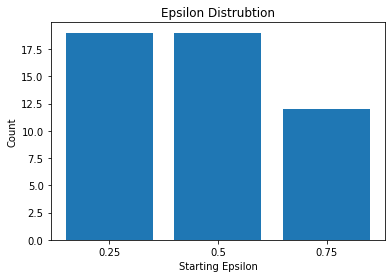

In [20]:
all_epsilon = []

for user in Users.population:
    all_epsilon.append(user.epsilon)

counts = {item:all_epsilon.count(item) for item in all_epsilon}

names = list(counts.keys())
values = list(counts.values())

plt.bar(range(len(counts)), values, tick_label=names)
bars = (0.25, 0.5, 0.75)
x_pos = np.arange(len(bars))

# Add title and axis names
plt.title('Epsilon Distrubtion')
plt.xlabel('Starting Epsilon')
plt.ylabel('Count')
 
# Create names on the x axis
plt.xticks(x_pos, bars)

plt.show()

In [21]:
user_1.epsilon

0.5

In [22]:
user_4.epsilon

0.75

In [30]:
user_12.epsilon

0.25

**Demo E-Greedy SpotifyDJ feature for one user**

Shows the song selection process of the e-greedy agent for one 10 song session.

Please enter a song to search: billie jean
Here are your results:
{1: ('Michael Jackson', 'Billie Jean', 'spotify:track:5ChkMS8OtdzJeqyybCc9R5'), 2: ('Daniela Andrade', 'Billie Jean', 'spotify:track:4spwpPKhuFed9huVCzhZqY'), 15: ('The Civil Wars', 'Billie Jean', 'spotify:track:4zzi2eD2cEPpQ3a307mPPj'), 32: ('Breathe Carolina', 'Billie Jean', 'spotify:track:6cCCIRyUhoJjKAfFVeAyxr'), 33: ('EDEN', 'Billie Jean', 'spotify:track:2zbq8QdgWACnYdKTu2xIE4'), 43: ('Tony Succar', 'Billie Jean', 'spotify:track:4PEZnG83tmFk12OPLCAHq0'), 68: ('Chris Cornell', 'Billie Jean', 'spotify:track:5le0k7yvbMCHH2Xa1tEpAL'), 74: ('Dawn Richard', 'Billie Jean', 'spotify:track:6qAAdFrQNKkN2yDJN9sR1I'), 94: ('Vitamin String Quartet', 'Billie Jean', 'spotify:track:7kD8PZ5JMJDs2KaXy0Dkgb')}
Please select the key of song dictionary you would like to select, or press 0 to exit. 1
Now Playing:
Billie Jean by Michael Jackson

Now Playing:
Baby You're Bad by HONNE
----------------------
Reward given: -5
Current q-values

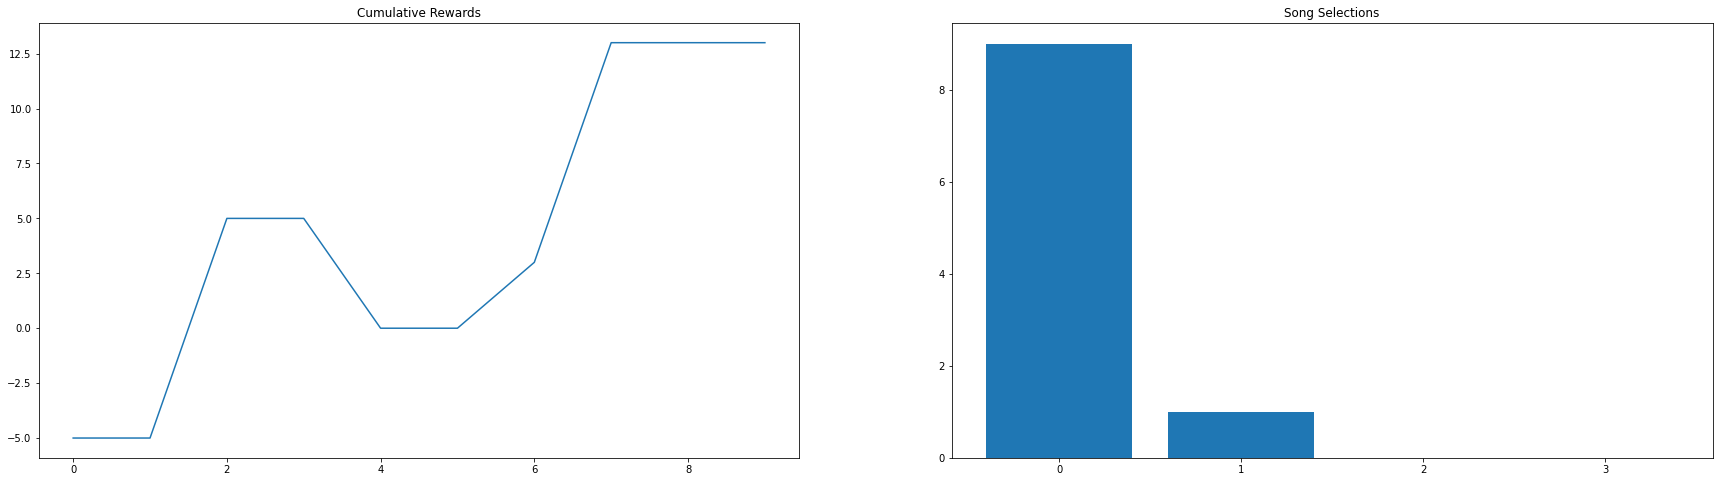

In [31]:
user_12.spotifyDJ()

**Demo SpotifyDJ feature simulated for a total of 1000 songs**

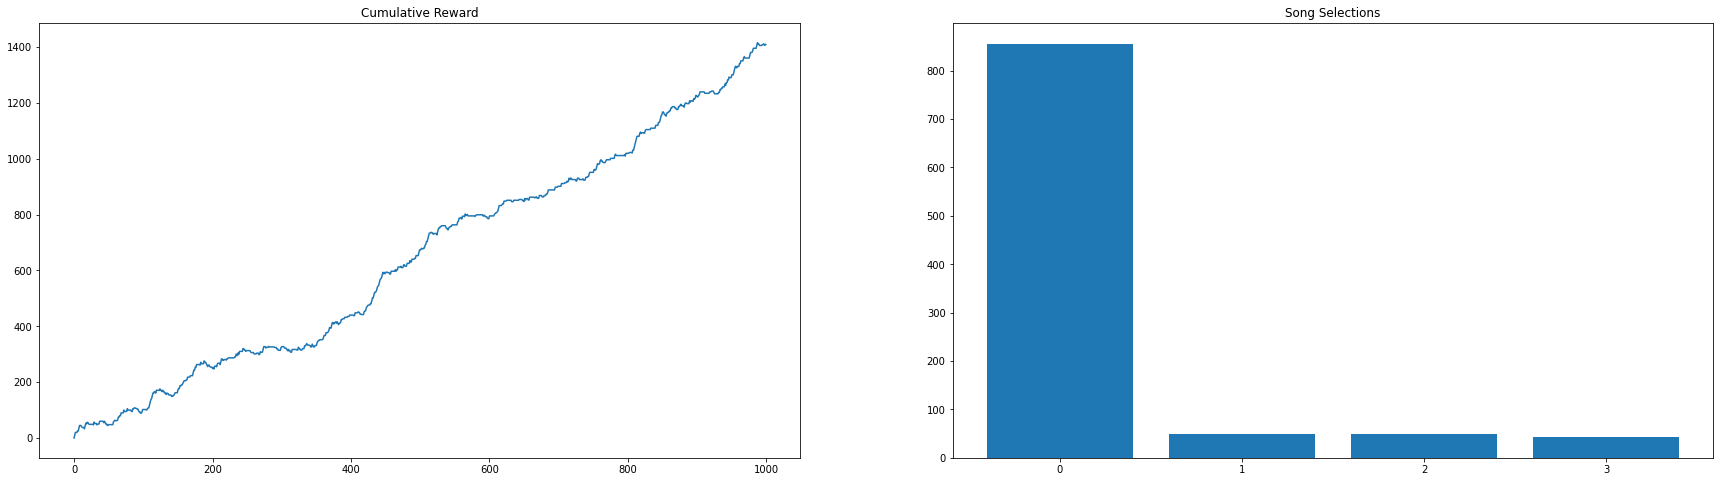

Total rewards after 1000 songs: 1409.0


In [32]:
count, cumulative = user_12.simulate_egreedy()

fig = plt.figure(figsize = [30,8])
ax2 = fig.add_subplot(121)
ax2.plot([i for i in range(len(cumulative))], cumulative)
ax2.set_title("Cumulative Reward")

ax3 = fig.add_subplot(122)
ax3.bar([i for i in range(len(count))], count, label = 'chosen arms')
ax3.set_title("Song Selections")
ax3.set_xticks([i for i in range(len(count))], [i for i in range(len(count))])

plt.show()

print(f"Total rewards after 1000 songs: {cumulative[-1]}")


**Demo random agent SpotifyDJ feature for one user**

Please enter a song to search: billie jean
Here are your results:
{1: ('Michael Jackson', 'Billie Jean', 'spotify:track:5ChkMS8OtdzJeqyybCc9R5'), 2: ('Daniela Andrade', 'Billie Jean', 'spotify:track:4spwpPKhuFed9huVCzhZqY'), 15: ('The Civil Wars', 'Billie Jean', 'spotify:track:4zzi2eD2cEPpQ3a307mPPj'), 32: ('Breathe Carolina', 'Billie Jean', 'spotify:track:6cCCIRyUhoJjKAfFVeAyxr'), 33: ('EDEN', 'Billie Jean', 'spotify:track:2zbq8QdgWACnYdKTu2xIE4'), 43: ('Tony Succar', 'Billie Jean', 'spotify:track:4PEZnG83tmFk12OPLCAHq0'), 68: ('Chris Cornell', 'Billie Jean', 'spotify:track:5le0k7yvbMCHH2Xa1tEpAL'), 74: ('Dawn Richard', 'Billie Jean', 'spotify:track:6qAAdFrQNKkN2yDJN9sR1I'), 94: ('Vitamin String Quartet', 'Billie Jean', 'spotify:track:7kD8PZ5JMJDs2KaXy0Dkgb')}
Please select the key of song dictionary you would like to select, or press 0 to exit. 1
Now Playing:
Billie Jean by Michael Jackson

Now Playing:
Black Cat by Janet Jackson
----------------------
Reward given: -2
Song Count: [0

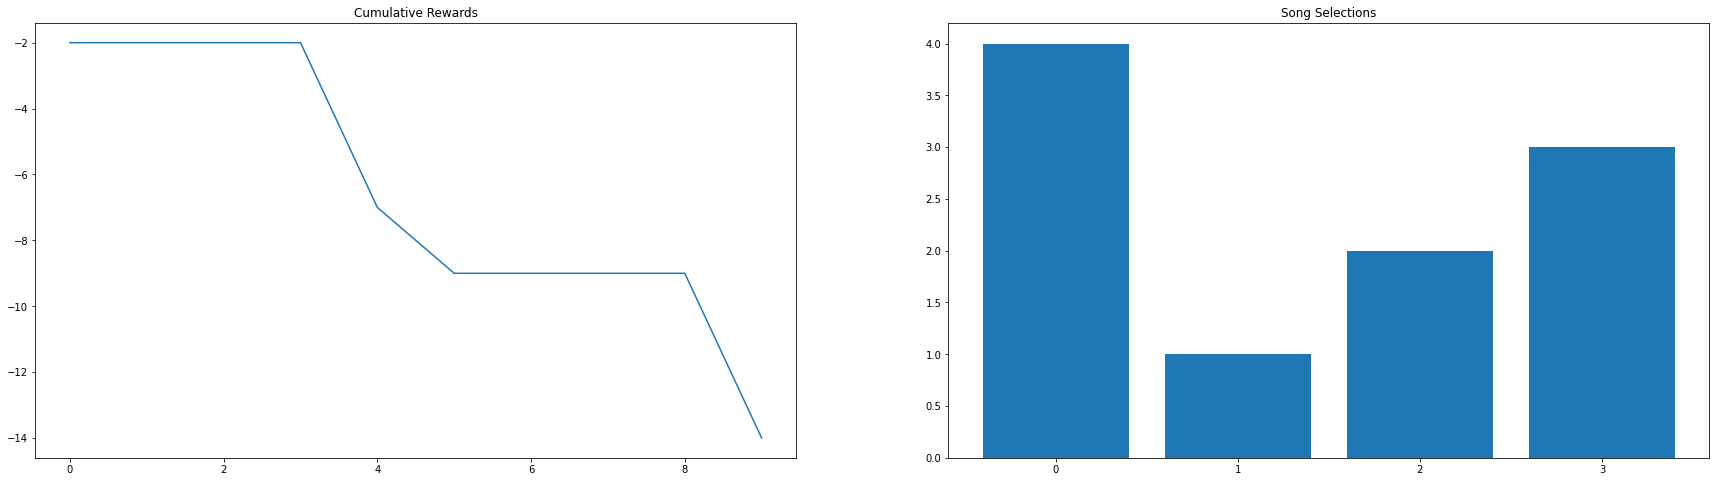

In [33]:
user_12.randomDJ()

**1000 song simulation using random agent**

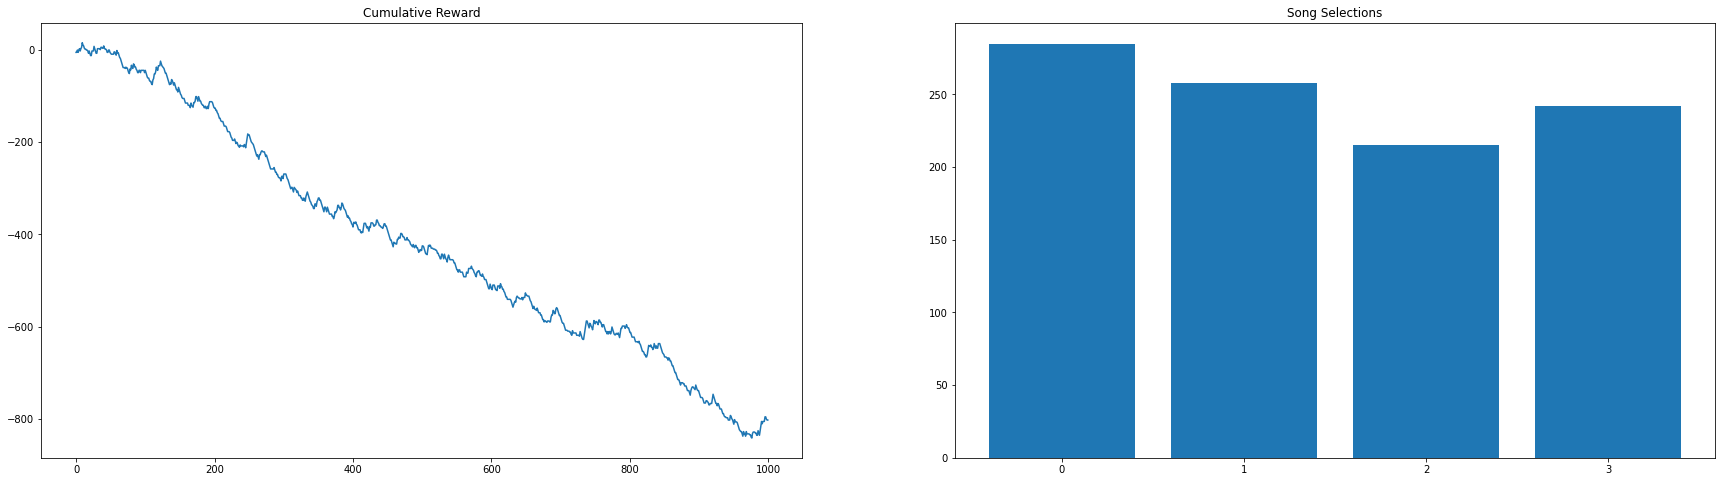

Total rewards after 1000 songs: -803.0


In [34]:
count, cumulative = user_12.simulate_random_agent()

fig = plt.figure(figsize = [30,8])
ax2 = fig.add_subplot(121)
ax2.plot([i for i in range(len(cumulative))], cumulative)
ax2.set_title("Cumulative Reward")

ax3 = fig.add_subplot(122)
ax3.bar([i for i in range(len(count))], count, label = 'chosen arms')
ax3.set_title("Song Selections")
ax3.set_xticks([i for i in range(len(count))], [i for i in range(len(count))])

plt.show()

print(f"Total rewards after 1000 songs: {cumulative[-1]}")



**Simulate e-greedy spotifyDJ feature for one user with very diverse epsilon**

Please enter a song to search: billie jean
Here are your results:
{1: ('Michael Jackson', 'Billie Jean', 'spotify:track:5ChkMS8OtdzJeqyybCc9R5'), 2: ('Daniela Andrade', 'Billie Jean', 'spotify:track:4spwpPKhuFed9huVCzhZqY'), 15: ('The Civil Wars', 'Billie Jean', 'spotify:track:4zzi2eD2cEPpQ3a307mPPj'), 32: ('Breathe Carolina', 'Billie Jean', 'spotify:track:6cCCIRyUhoJjKAfFVeAyxr'), 33: ('EDEN', 'Billie Jean', 'spotify:track:2zbq8QdgWACnYdKTu2xIE4'), 43: ('Tony Succar', 'Billie Jean', 'spotify:track:4PEZnG83tmFk12OPLCAHq0'), 68: ('Chris Cornell', 'Billie Jean', 'spotify:track:5le0k7yvbMCHH2Xa1tEpAL'), 74: ('Dawn Richard', 'Billie Jean', 'spotify:track:6qAAdFrQNKkN2yDJN9sR1I'), 94: ('Vitamin String Quartet', 'Billie Jean', 'spotify:track:7kD8PZ5JMJDs2KaXy0Dkgb')}
Please select the key of song dictionary you would like to select, or press 0 to exit. 1
Now Playing:
Billie Jean by Michael Jackson

Now Playing:
Uptown Funk (feat. Bruno Mars) by Mark Ronson
----------------------
Reward given

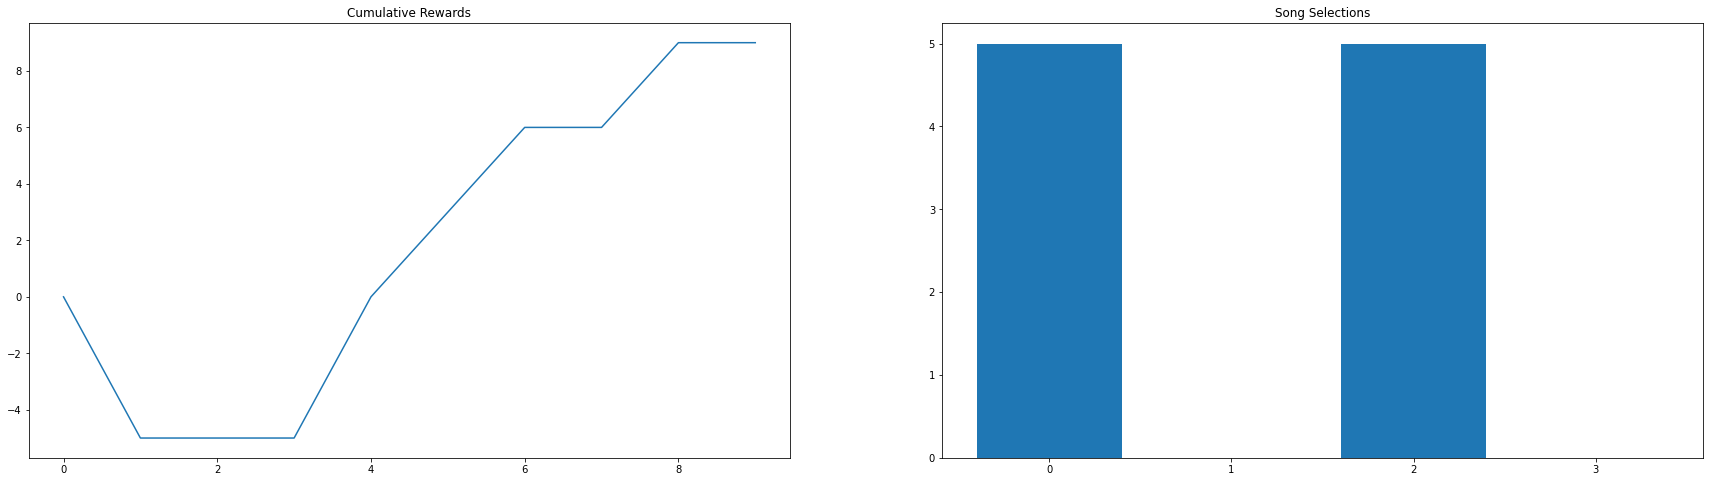

In [35]:
user_4.spotifyDJ()

**1000 song simulation using e-greedy**

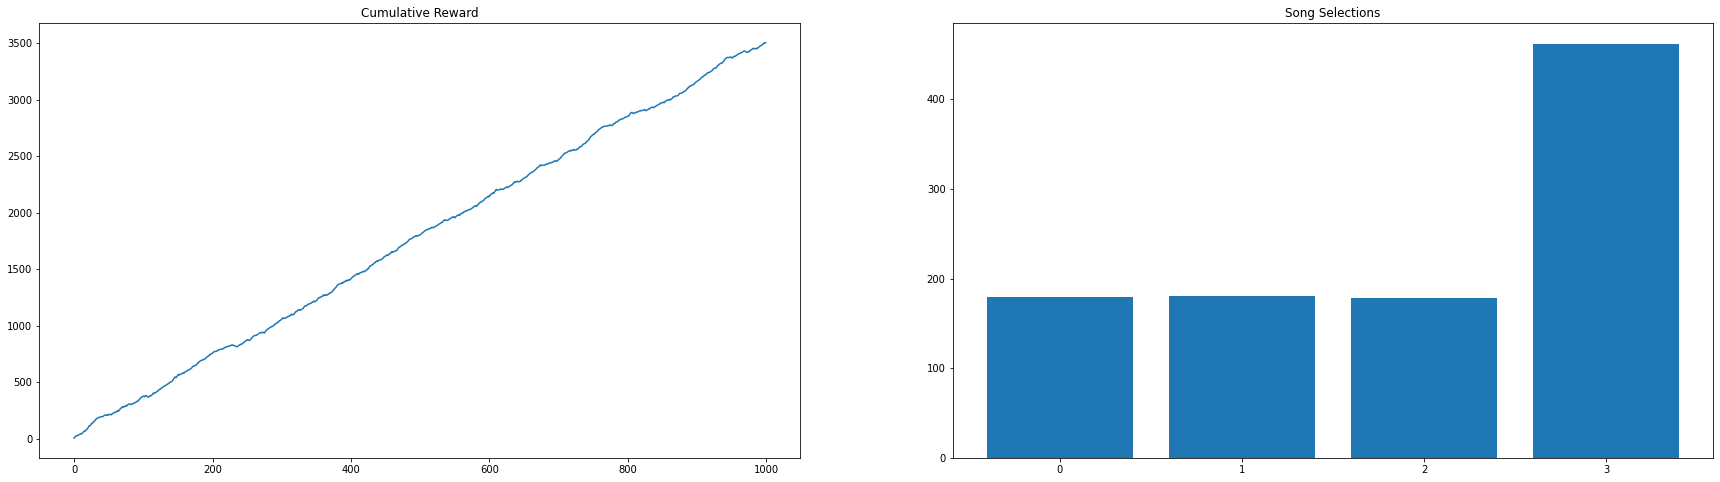

Total rewards after 1000 songs: 3504.0


In [36]:
count, cumulative = user_4.simulate_egreedy()

fig = plt.figure(figsize = [30,8])
ax2 = fig.add_subplot(121)
ax2.plot([i for i in range(len(cumulative))], cumulative)
ax2.set_title("Cumulative Reward")

ax3 = fig.add_subplot(122)
ax3.bar([i for i in range(len(count))], count, label = 'chosen arms')
ax3.set_title("Song Selections")
ax3.set_xticks([i for i in range(len(count))], [i for i in range(len(count))])

plt.show()

print(f"Total rewards after 1000 songs: {cumulative[-1]}")



**Demo random agent for one user with diverse epsilon**

Please enter a song to search: billie jean
Here are your results:
{1: ('Michael Jackson', 'Billie Jean', 'spotify:track:5ChkMS8OtdzJeqyybCc9R5'), 2: ('Daniela Andrade', 'Billie Jean', 'spotify:track:4spwpPKhuFed9huVCzhZqY'), 15: ('The Civil Wars', 'Billie Jean', 'spotify:track:4zzi2eD2cEPpQ3a307mPPj'), 32: ('Breathe Carolina', 'Billie Jean', 'spotify:track:6cCCIRyUhoJjKAfFVeAyxr'), 33: ('EDEN', 'Billie Jean', 'spotify:track:2zbq8QdgWACnYdKTu2xIE4'), 43: ('Tony Succar', 'Billie Jean', 'spotify:track:4PEZnG83tmFk12OPLCAHq0'), 68: ('Chris Cornell', 'Billie Jean', 'spotify:track:5le0k7yvbMCHH2Xa1tEpAL'), 74: ('Dawn Richard', 'Billie Jean', 'spotify:track:6qAAdFrQNKkN2yDJN9sR1I'), 94: ('Vitamin String Quartet', 'Billie Jean', 'spotify:track:7kD8PZ5JMJDs2KaXy0Dkgb')}
Please select the key of song dictionary you would like to select, or press 0 to exit. 1
Now Playing:
Billie Jean by Michael Jackson

Now Playing:
Get Ur Freak On by Missy Elliott
----------------------
Reward given: 10
Song Cou

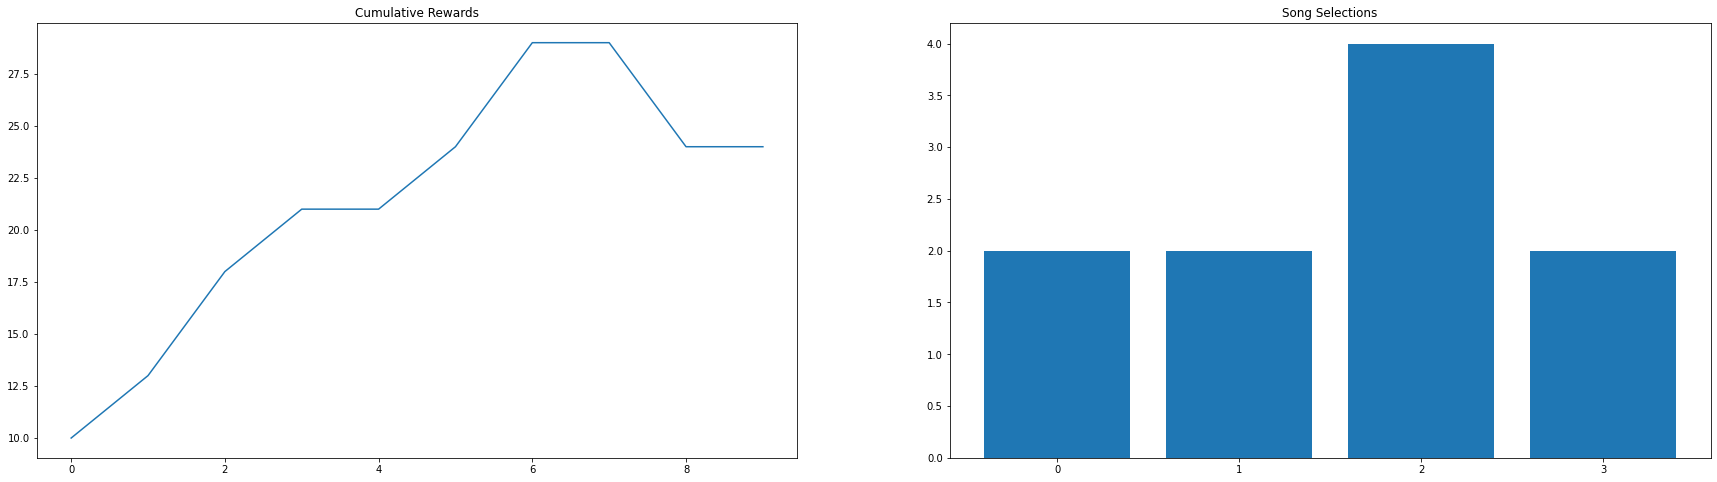

In [37]:
user_4.randomDJ()

**1000 song simulation using random agent for diverse epsilon user**

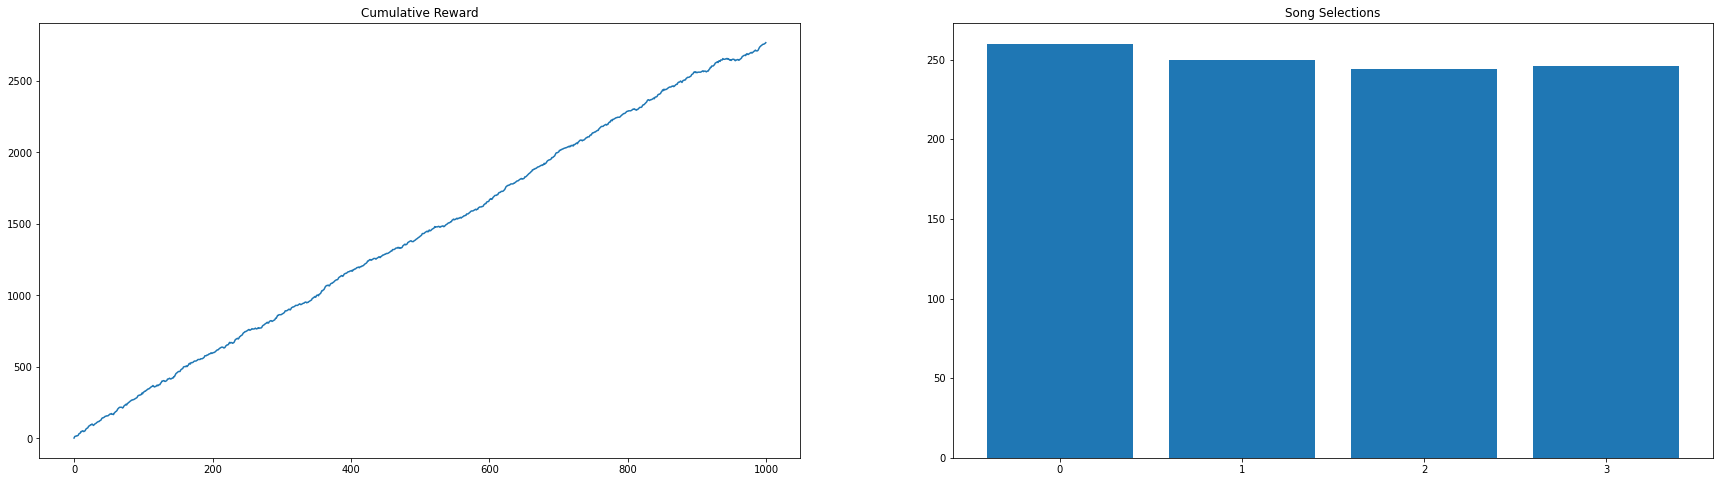

Total rewards after 1000 songs: 2766.0


In [38]:
count, cumulative = user_4.simulate_random_agent()

fig = plt.figure(figsize = [30,8])
ax2 = fig.add_subplot(121)
ax2.plot([i for i in range(len(cumulative))], cumulative)
ax2.set_title("Cumulative Reward")

ax3 = fig.add_subplot(122)
ax3.bar([i for i in range(len(count))], count, label = 'chosen arms')
ax3.set_title("Song Selections")
ax3.set_xticks([i for i in range(len(count))], [i for i in range(len(count))])

plt.show()

print(f"Total rewards after 1000 songs: {cumulative[-1]}")




**Simulate e-greedy agent for all users**

The average total rewards for all users with an e-greedy agent: 2629.84


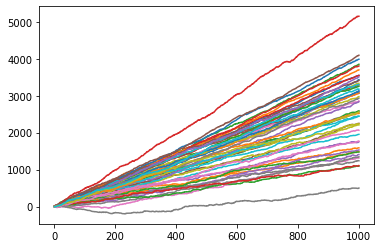

In [39]:
def simulate_all_egreedy():

    cumulative_rewards = []
    final_rewards = []

    for user in Users.population:
        count, cumulative = user.simulate_egreedy()
        cumulative_rewards.append(cumulative)
    
    for rewards in cumulative_rewards:
        final_rewards.append(rewards[-1])
    
    print(f"The average total rewards for all users with an e-greedy agent: {sum(final_rewards)/len(final_rewards)}")

    for y in cumulative_rewards:
        x = range(1, len(y)+1)
        plt.plot(x,y)
    plt.show()

simulate_all_egreedy()


**Simulate random agent for all users**

The average total rewards for all users with a random agent: 813.14


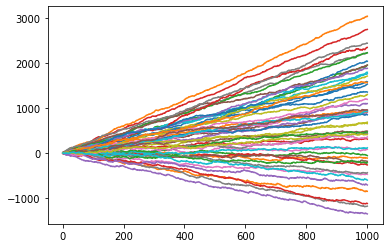

In [40]:
def simulate_random():

    cumulative_rewards = []
    final_rewards = []

    for user in Users.population:
        count, cumulative = user.simulate_random_agent()
        cumulative_rewards.append(cumulative)
    
    for rewards in cumulative_rewards:
        final_rewards.append(rewards[-1])
    
    print(f"The average total rewards for all users with a random agent: {sum(final_rewards)/len(final_rewards)}")

    for y in cumulative_rewards:
        x = range(1, len(y)+1)
        plt.plot(x,y)
    plt.show()

simulate_random()